<a href="https://colab.research.google.com/github/MaYuetong/MaYuetong/blob/main/%E2%80%9ClightGBM_urbanareas_Rntl_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git
!pip install shap
!pip install skopt
!pip install PyALE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2570k  100 2570k    0     0  9386k      0 --:--:-- --:--:-- --:--:-- 9416k
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-lbo4iwmk
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-lbo4iwmk
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyaml-23.9.7-py3-none-any.whl (23 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
#0.22以上版本的sklearn去除了Imputer类，因此需要使用SimpleImputer类代替
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import joblib
from PyALE import ale
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from skopt import BayesSearchCV


# X为14个自变量，y为6个类型变量`


data1 = pd.read_csv("/content/drive/MyDrive/data/DR_CZ.csv")



data = data1

# 2.切分数据输入：特征 输出：预测目标变量
y = data.Rntl #因变量1个
X = data.drop(['Rntl','Type', 'wind916', 'wind917', 'prec916', 'prec917','LUCC', 'NC_pre', 'landuse_2', 'NDVI_Oct', 'NDVI_Sep', 'NDVI(8_9)', 'NDVI(8_10)',  ], axis=1)#.select_dtypes(exclude=['object']),'NC','LUCC','NC_pre'
#自变量14个（一个自变量为一个特征：feature）,



feature_list = X.columns.tolist() #特征排成一列
print('Feature importances:', feature_list)

# 3.切分训练集、测试集,切分比例7.5 : 2.5
train_X, test_X, train_y, test_y = train_test_split(X.values, y.values, test_size=0.25, random_state=42)

#显示训练集测试集长度
print("Train data length_CZ_DNTL:", len(train_X))
print("Test data length_CZ_DNTL:", len(test_X))

# 4.空值处理，默认方法：使用特征列的平均值进行填充
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

# 将NC列转换为类别的类型
#X['landuse_2'] = X['landuse_2'].astype ('category')
#X['Landuse'] = X['Landuse'].astype ('category')

#categorical_features = ['Landuse']#'landuse_2',


Feature importances: ['Dntl', 'ND', 'DEM', 'GDP', 'RD', 'WD', 'PD', 'SL', 'DR', 'wind918', 'prec918', 'MWS_3D', 'AWS_3D', 'MPP_3D', 'APP_3D', 'Landuse', 'NDVI_Aug', 'NDVI(9_10)', 'SD']
Train data length_CZ_DNTL: 4660
Test data length_CZ_DNTL: 1554


In [ ]:
# 定义LightGBM回归器
lgb_reg = lgb.LGBMRegressor(random_state=42)
# 定义贝叶斯优化的参数空间
# 定义贝叶斯优化的参数空间
search_space = {
    'learning_rate': (0.01, 0.1, 'log-uniform'), # 学习率，一般设置在0.01到0.1之间
    'n_estimators': (100, 500), # 决策树的数量，一般设置在100到500之间
    'num_leaves': (10, 255), # 叶子节点的数量，一般设置在10到100之间，且小于2的max_depth次方减一
    'max_depth': (2, 8), # 树的最大深度，一般设置在2到6之间
    'min_child_samples': (int(0.01 * 5000), int(0.25 * 5000)), # 一个叶子节点上的最小样本数，一般设置为数据集大小除以特征数量的一个比例，比如0.01到0.25
    'min_child_weight': (0.001, 0.1), # 一个叶子节点上的最小hessian和，一般设置为0.001到0.1之间
    'reg_alpha': (0.0, 100.0), # L1正则化的系数，一般设置在0到100之间
    'reg_lambda': (0.0, 100.0), # L2正则化的系数，一般设置在0到100之间
    'subsample': (0.5, 1.0), # 训练每棵树时的样本比例，一般设置在0.5到1.0之间
    'colsample_bytree': (0.5, 1.0) # 训练每棵树时的特征比例，一般设置在0.5到1.0之间
  }
# 定义贝叶斯优化搜索器
bayes_search = BayesSearchCV(lgb_reg, search_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
# 进行贝叶斯优化搜索
bayes_search.fit(train_X, train_y)
# 打印最优参数和最优分数
print(f'Best parameters for CZ_DNTL: {bayes_search.best_params_}')
print(f'Best score for CZ_DNTL: {bayes_search.best_score_}')
# 使用最优参数训练LightGBM回归器
best_lgb_reg = lgb.LGBMRegressor(**bayes_search.best_params_, random_state=42)
best_lgb_reg.fit(train_X, train_y)
# Using the best parameters to train the LightGBM regressor
# 对测试集进行预测
y_pred = best_lgb_reg.predict(test_X)
# 计算评估指标
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
r2 = r2_score(test_y, y_pred)
me = mean_absolute_error(test_y, y_pred)
# 打印评估指标
print(f'RMSE for CZ_DNTL: {rmse}')
print(f'R2 for CZ_DNTL: {r2}')
print(f'ME for CZ_DNTL: {me}')

# 对训练集进行预测
y_pred = best_lgb_reg.predict(train_X)
# 计算评估指标
rmse = np.sqrt(mean_squared_error(train_y, y_pred))
r2 = r2_score(train_y, y_pred)
me = mean_absolute_error(train_y, y_pred)
# 打印评估指标
print(f'RMSE for train_CZ_DNTL: {rmse}')
print(f'R2 for train_CZ_DNTL: {r2}')
print(f'ME for train_CZ_DNTL: {me}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 4660, number of used features: 19
[LightGBM] [Info] Start training from score 0.181356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
# 定义绘图函数
from sklearn.model_selection import learning_curve
def plot_learning_curve(model, X, y, cv=5):
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='neg_mean_squared_error')
  train_scores_mean = -np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = -np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.figure()
  plt.title(f'Learning Curve of {model.__class__.__name__}')
  plt.xlabel('Training examples')
  plt.ylabel('Mean Squared Error')
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1,
                   color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
           label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
           label='Cross-validation score')
  plt.legend(loc='best')
  plt.show()


# 使用LightGBM绘制Dntl的学习曲线
plot_learning_curve(lgb_reg, X, y)

# 使用LightGBM绘制Rntl的学习曲线
plot_learning_curve(lgb_reg, X, y)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 4660, number of used features: 19
[LightGBM] [Info] Start training from score 0.181356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<ipython-input-15-fb3edd111ffa>:83: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df_fi.head(top).plot(kind='barh',


<Figure size 1920x1440 with 0 Axes>

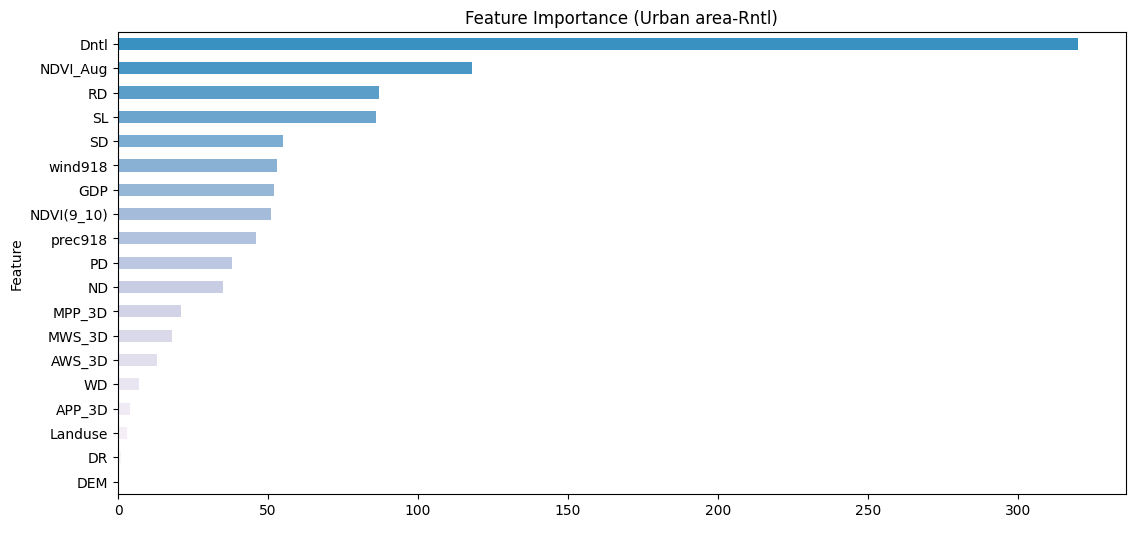

In [ ]:
# 5.调用LightGBM模型，使用训练集数据进行训练（拟合）
# Add verbosity=2 to print messages while running boosting
# 定义LightGBM回归器，并设置参数
my_model = lgb.LGBMRegressor(
    colsample_bytree = 1.0,
    learning_rate = 0.025764926555960053,
    max_depth = 2,
    min_child_samples = 50,
    min_child_weight = 0.06836695458476909,
    n_estimators = 350,
    num_leaves = 10,
    reg_alpha = 0.0,
    reg_lambda = 0.0,
    subsample = 0.5,
    random_state = 42 # 设置随机种子，保证结果可复现
)

# 6.使用fit函数拟合
my_model.fit(train_X, train_y)
a=my_model.score(test_X,test_y)
print("my_model_score:",a)

# 7.保存模型，并打分
joblib.dump(my_model,"my_model_nc.dat")
a=my_model.score(test_X,test_y)
print("my_model_score:",a)
# 8.加载模型，并打分
load_model = joblib.load("my_model_nc.dat")
b=load_model.score(test_X,test_y)
print("load_model_score:",b)


# 9.使用my_model对测试集数据进行预测预测
print('开始预测...')
y_pred = my_model.predict(test_X, num_iteration=my_model.best_iteration_)
# 9.1.评估预测结果（RMSE,ME，R方）
# 9.1.1 RMSE
print('预测结果的rmse是:')
print(mean_squared_error(test_y, y_pred) ** 0.5)
# 9.1.2 ME（平均绝对误差）
print("Mean Absolute Error : " + str(mean_absolute_error(y_pred, test_y)))
# 9.1.3 R方（相关系数）
print("r2_score : ")
print(r2_score(test_y, y_pred))


# 10.使用load模型对测试集数据进行预测
load_pred = load_model.predict(test_X, num_iteration=load_model.best_iteration_)
# 10.1 评估load模型预测结果（RMSE,ME，R方）
# 10.1.1 RMSE
print('Load模型预测结果的rmse是:')
print(mean_squared_error(test_y, load_pred) ** 0.5)
# 10.1.2 ME（平均绝对误差）
print("Load模型的Mean Absolute Error : " + str(mean_absolute_error(load_pred, test_y)))
# 10.1.3 R方（相关系数）
print("r2_score : ")
print(r2_score(test_y, load_pred))
# 对训练集进行预测
load_pred = load_model.predict(train_X, num_iteration=load_model.best_iteration_)
# 计算评估指标
rmse = np.sqrt(mean_squared_error(train_y, load_pred))
r2 = r2_score(train_y, load_pred)
me = mean_absolute_error(train_y, load_pred)
# 打印评估指标
print(f'RMSE for train_CZ_DNTL: {rmse}')
print(f'R2 for train_CZ_DNTL: {r2}')
print(f'ME for train_CZ_DNTL: {me}')

# 特征重要度
print('Feature importances:', list(my_model.feature_importances_))
feature_importance = my_model.feature_importances_
#方法一画特征重要性图
data2 = {'feature': ['Dntl', 'ND', 'DEM', 'GDP', 'RD', 'WD', 'PD', 'SL', 'DR', 'wind918', 'prec918', 'MWS_3D', 'AWS_3D', 'MPP_3D', 'APP_3D', 'Landuse', 'NDVI_Aug', 'NDVI(9_10)', 'SD'],
        'importance': (feature_importance)}#创建数据,文本和单独的数字用['']表示，存有数据的对象用()才能够顺利读取到上面文本对应的每一个格子！
df_fi = pd.DataFrame(data2)
print(df_fi)
df_fi.sort_values(by=['importance'],axis=0,ascending=True,inplace=True)
print(df_fi)

top = 30
# 创建图形
plt.figure(1, dpi=300) # 增加dpi参数提高图像清晰度
df_fi.head(top).plot(kind='barh',
                     x='feature',
                     y='importance',
                     sort_columns=True,
                     legend=False,
                     figsize=(13, 6),
                     color=plt.cm.PuBu(np.linspace(0, 1, top), alpha=1))
                     # 使用渐变色彩映射改变柱状图的配色 color=plt.cm.viridis(np.linspace(0, 1, top))
plt.title('Feature Importance (Urban area-Rntl)')
plt.xlabel(' ')
plt.ylabel('Feature', fontname='Times New Roman')
#plt.savefig('/content/drive/MyDrive/data/CZ_RNTL_import.png', dpi=300, bbox_inches='tight')
from google.colab import files
#files.download('/content/drive/MyDrive/data/CZ_RNTL_import.png')

# Plots ALE of feature 'cont' with Monte-Carlo replicas (default : 50).
#you can find feature in 'feature_list'
#Dntl_____绘制ALE曲线
## 1D - continuous - with 95% CI


INFO:PyALE._ALE_generic:Continuous feature detected.


Dntl /
ND m
DEM m
GDP milion/km²
RD km/km²
WD km/km²
PD per/km²
SL degree
DR km
wind918 m/s
prec918 0.01mm
MWS_3D m/s
AWS_3D m/s
MPP_3D 0.01mm
APP_3D 0.01mm
Landuse /
NDVI_Aug /
NDVI(9_10) /
SD per/km²


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Discrete feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:PyALE._ALE_generic:Continuous feature detected.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

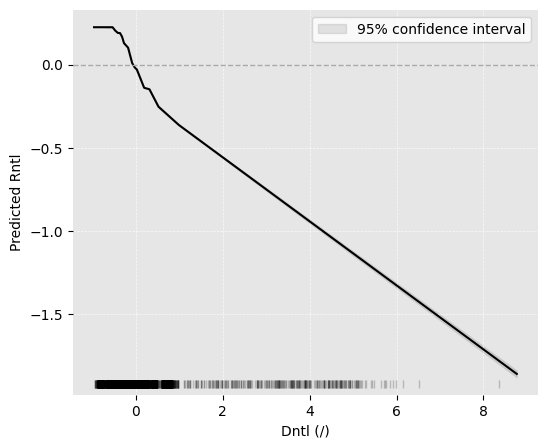

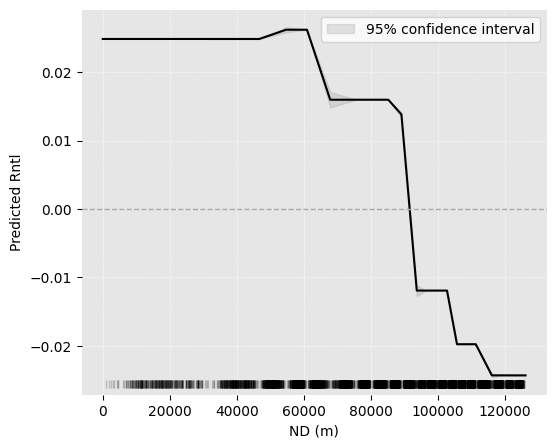

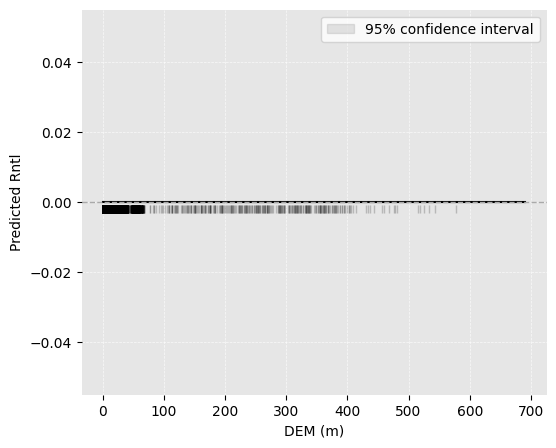

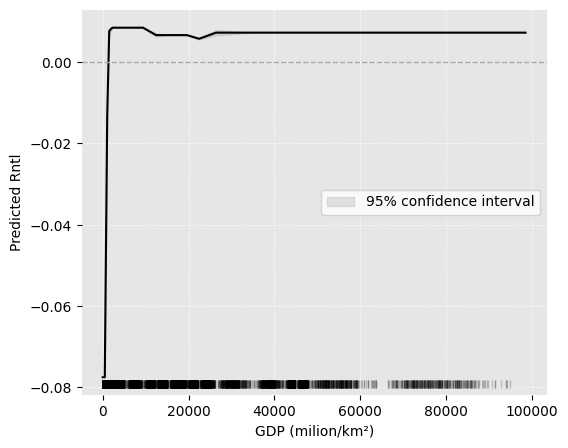

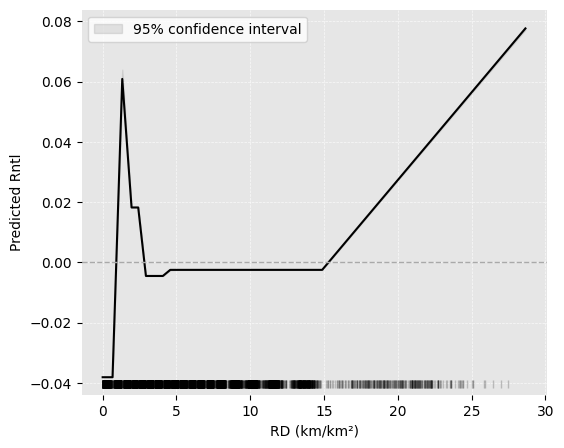

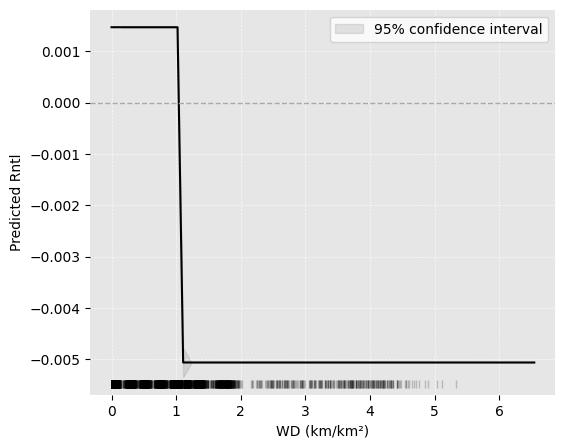

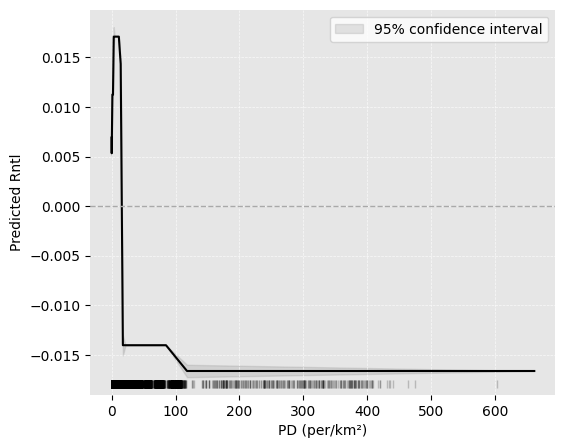

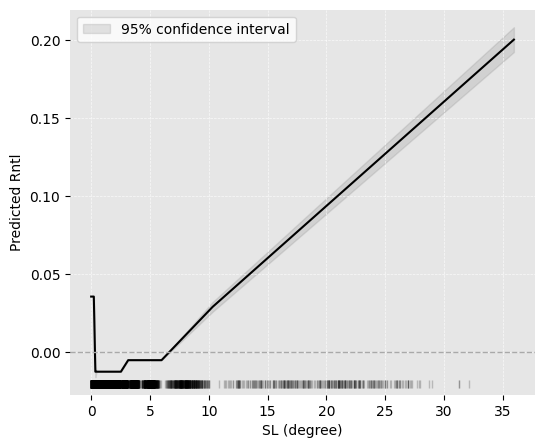

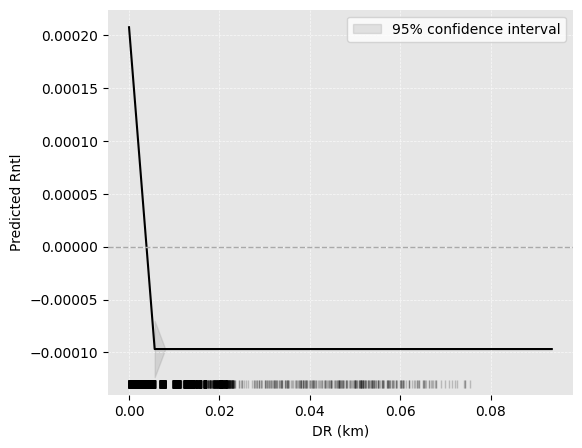

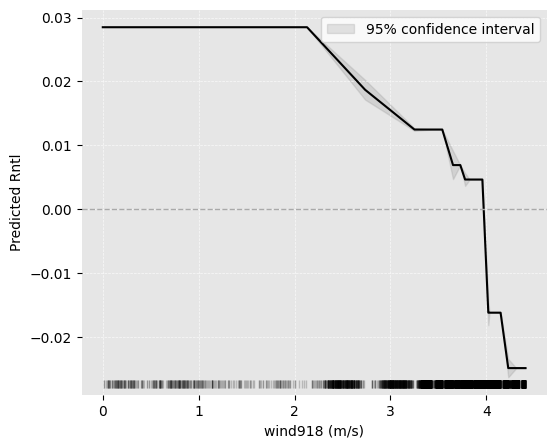

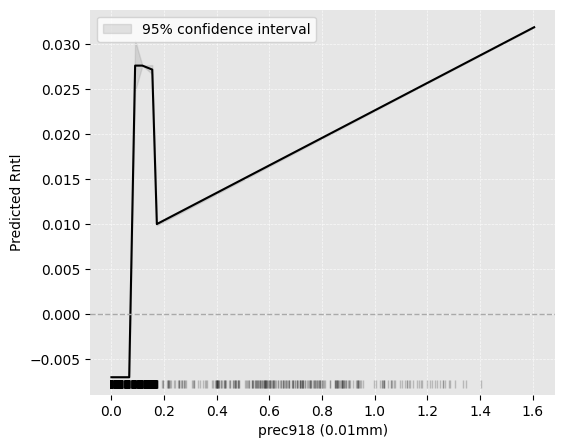

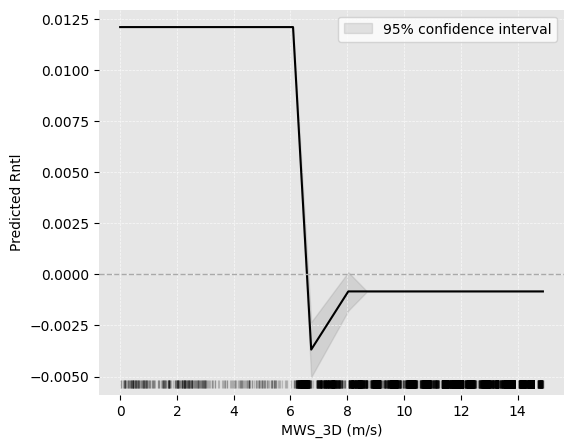

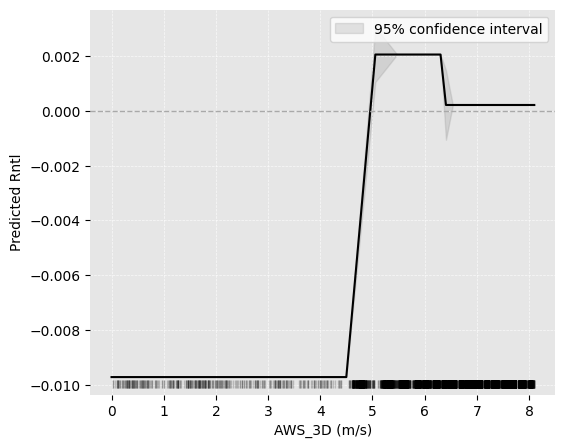

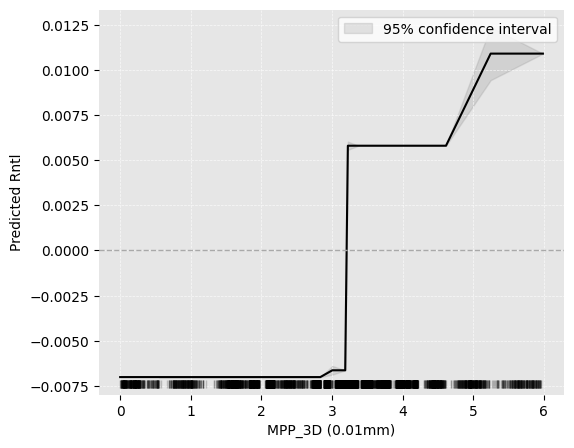

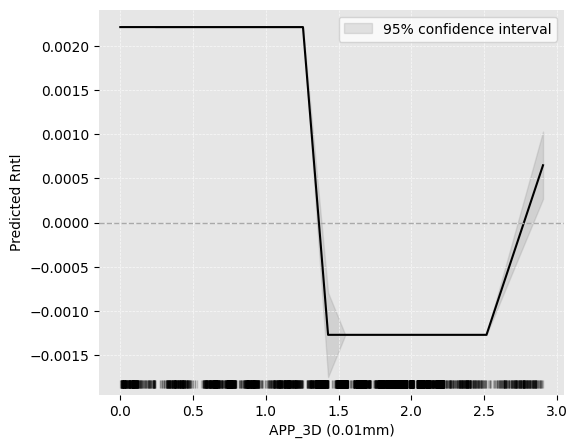

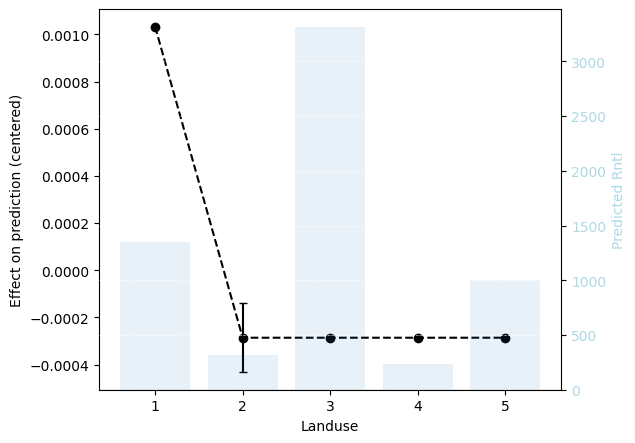

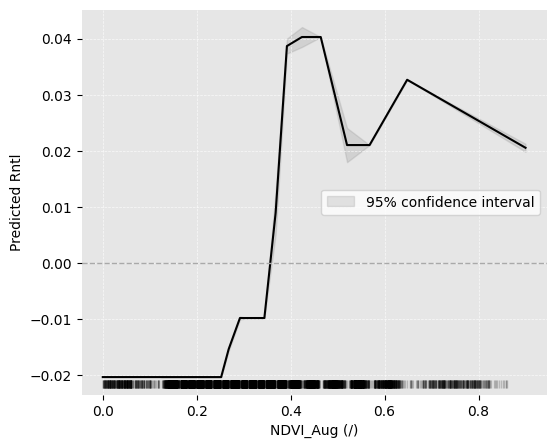

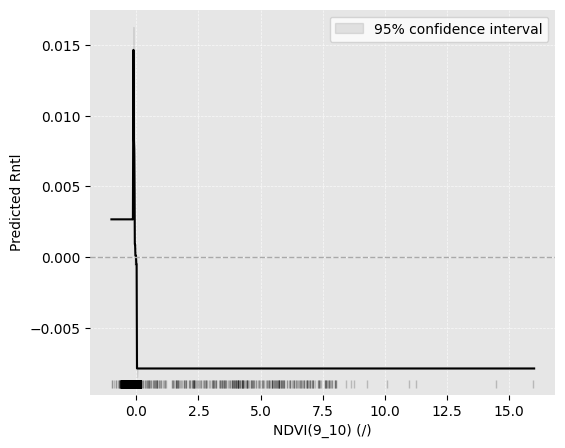

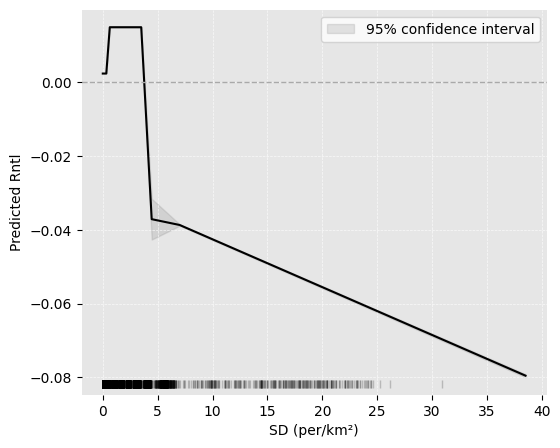

In [ ]:
# 导入PyALE模块
import PyALE
import matplotlib

# 定义你的19个特征的列表
#features = ['Rntl', 'ND', 'DEM', 'GDP', 'RD', 'WD', 'PD', 'SL', 'DR', 'wind918', 'prec918',
#           'MWS_3D', 'AWS_3D', 'MPP_3D', 'APP_3D', 'Landuse', 'NDVI_Aug', 'NDVI(9_10)', 'SD']

# 为每个特征创建一个字典，存储它们的单位，例如米、百分比等，根据您的数据类型选择合适的单位
units = {'Dntl': '/', 'ND': 'm', 'DEM': 'm', 'GDP': 'milion/km\u00B2', 'RD': 'km/km\u00B2', 'WD': 'km/km\u00B2', 'PD': 'per/km\u00B2',
         'SL': 'degree', 'DR': 'km', 'wind918': 'm/s', 'prec918': '0.01mm', 'MWS_3D': 'm/s', 'AWS_3D': 'm/s', 'MPP_3D': '0.01mm',
         'APP_3D': '0.01mm', 'Landuse': '/', 'NDVI_Aug': '/', 'NDVI(9_10)': '/', 'SD': 'per/km\u00B2'}

# 使用Unicode字符实现上标效果
for feature, unit in units.items():
  print(feature, unit)

# 定义一个name属性给您的模型，赋值为您想要的模型名
my_model.name = 'CZ_Rntl'


# 循环遍历每个特征，绘制并保存ALE图
for feature in feature_list:
  # 计算并绘制ALE图
  ale_eff = ale(X, model=my_model, feature=[feature], grid_size=20, include_CI=True, C=0.95)
  # 使用plt.title()函数去掉标题，指定label参数为空字符串
  plt.title(label='')
  # 从字典中获取相应的单位，并添加到坐标轴的标签中
  plt.xlabel(feature + ' (' + units[feature] + ')')
  plt.ylabel('Predicted Rntl')
  # 或者使用plt.gcf().findobj()函数查找当前图像中的线条对象
  lines = plt.gcf().findobj(matplotlib.lines.Line2D)
  # 遍历线条对象，设置颜色为黑色
  for line in lines:
    line.set_color('black')
  # 使用plt.gca().set_facecolor()函数设置图像的背景颜色为浅灰色
  plt.gca().set_facecolor('lightgray')
  # 使用plt.gca().spines属性隐藏边框
  ax = plt.gca()
  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_color('none')
  ax.spines['left'].set_color('none')
  ax.spines['right'].set_color('none')
  # 使用plt.gca().set_facecolor()函数设置背景颜色为浅灰色
  ax.set_facecolor('#E6E6E6')
  # 使用plt.gca().grid()函数添加白色的稀疏的网格线
  ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.8)
    # 使用plt.axhline()函数在y=0处加一条深灰色的虚线
  plt.axhline(y=0, color='darkgray', linestyle='--',linewidth=1.0,)
  # 使用plt.suptitle()函数去掉标题，指定t参数为空字符串
  plt.suptitle(t='')
  # 调整图像的大小，使其符合的比例
  plt.gcf().set_size_inches(6, 5)
  #保存ALE图到你的Google Drive，文件名为模型名_特征名_ALE.png
  plt.savefig('/content/drive/MyDrive/data/{}_{}_ALE.png'.format(my_model.name, feature), dpi=300, bbox_inches='tight')
  #下载ALE图到你的电脑，文件名同上
  from google.colab import files
  files.download('/content/drive/MyDrive/data/{}_{}_ALE.png'.format(my_model.name, feature))

